In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# For saving dictionaries
import pickle

# Data visualization
import matplotlib.pyplot as plt

# For neural networks
import torch

# Computation of asset metrics
from portfolio_stats import PortfolioStats

# Time series splitting for walk forward modeling
from sklearn.model_selection import TimeSeriesSplit

# Neural network portfolio optimizer and objective functions
from workflow.tools.leverage_models import LSTMPortOpt_L, CNNPortOpt_L
from workflow.tools.metrics import neg_sharpe_ratio

# Transaction costs
from workflow.tools.transaction_costs import net_tc

# Tensor transform
from workflow.tools.conversion import to_tensors

from workflow.tools.utils import set_plot_style, plot_allocations

set_plot_style()

In [2]:
# Load data
kwargs = {
    "index_col": 0,
    "parse_dates": True
}

features = pd.read_csv("workflow/data/features.csv", **kwargs)

features.head()

,BONDS,COMMODITIES,STOCKS,VOLATILIITY,BONDS_RET,COMMODITIES_RET,STOCKS_RET,VOLATILIITY_RET
Date,,,,,,,,
2006-02-07,58.516796,21.282080,44.861336,13.59,-0.000699,-0.029352,-0.009784,0.041313
2006-02-08,58.487652,21.191517,45.184078,12.83,-0.000498,-0.004264,0.007168,-0.057548
2006-02-09,58.522652,21.390755,45.098019,13.12,0.000598,0.009358,-0.001906,0.022352
2006-02-10,58.399944,21.001339,45.191254,12.87,-0.002099,-0.018373,0.002065,-0.019239
2006-02-13,58.440830,20.675316,44.986858,13.35,0.000700,-0.015646,-0.004533,0.036617


In [3]:
# Define lookback window
lookback = 50
n_samples = len(features) - lookback
n_features = len(features.columns)

# Get columns related to returns, and index names
return_cols = [col for col in features.columns if "RET" in col]
indices = features.columns[~features.columns.isin(return_cols)]

# Initialize input data with zeros
X = np.zeros((n_samples, lookback, n_features))

# Extract target values starting from the lookback index
y = features[return_cols].iloc[lookback:].values

# Populate the 'X' tensor using a rolling window of size 'lookback'
for i in range(lookback, len(features)):
    X[i-lookback] = features.iloc[i-lookback:i]

X.shape, y.shape

((4403, 50, 8), (4403, 4))

In [4]:
# Set random seed (torch) for reproducibility
torch.manual_seed(42)

# Initialize models dictionary
models = {
    "LSTM": LSTMPortOpt_L,
    "CNN": CNNPortOpt_L
}

# Initialize empty weights dictionary
weights = {model: [] for model in models.keys()}

# Define number of trading days per year and initialize TimeSeriesSplit
trading_days = 252
retrain_after = 2
tss = TimeSeriesSplit(test_size=trading_days*retrain_after)
val_size = .2 # 20% validation window

# Loop over model
for a, (name, model_) in enumerate(models.items()):
    
    print(f"{a+1}: {name}", end="\n")

    if name == "CNN":
        X = X.transpose(0, 2, 1)

    for e, (train_idx, test_idx) in enumerate(tss.split(X)):
        
        val_idx = int(len(train_idx) * (1 - val_size))
        
        # Split data
        X_train, X_val, X_test = X[:val_idx], X[val_idx:], X[test_idx]
        y_train, y_val, y_test = y[:val_idx], y[val_idx:], y[test_idx]

        # Convert inputs and targets to PyTorch tensors
        X_train, X_val, X_test, y_train, y_val, y_test = to_tensors(
            X_train, X_val, X_test, y_train, y_val, y_test
        )

        # Define input size, hidden size, and output size
        if name == "CNN":
            input_size = X.shape[1] # 8 channels for CNN
        else: 
            input_size = X_train.shape[-1]     # 8 features
        hidden_size = 64                       # 64 neurons
        output_size = y_train.shape[-1]        # 4 assets

        # Initialize model and optimizer
        model = model_(input_size, hidden_size, output_size)
        optimizer = torch.optim.Adam(model.parameters())

        # Define number of epochs
        epochs = 100

        # Construct training loop
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train)
            obj = neg_sharpe_ratio(outputs, y_train)
            obj.backward()
            optimizer.step()

            # Evaluate validation performance
            with torch.no_grad():
                val_allocations = model(X_val)
                val_obj = neg_sharpe_ratio(val_allocations, y_val)
            
            print(
                f"Split {e+1}: Epoch {epoch+1}/{epochs} ({(epoch+1)/epochs*100:,.2f}%)",
                "|",
                f"Train: {-obj.item():,.5f}", 
                f"Val: {-val_obj.item():,.5f}" ,
                end="\r"
            )

        print()
        
        # Get the outputs (asset allocations) after training
        with torch.no_grad():
            model_allocations = model(X_test)
            weights[name].append(model_allocations)
    
    print()

1: LSTM
Split 1: Epoch 100/100 (100.00%) | Train: 3.41096 Val: 0.88824
Split 2: Epoch 100/100 (100.00%) | Train: 2.74788 Val: 0.78165
Split 3: Epoch 100/100 (100.00%) | Train: 2.83118 Val: 0.94020
Split 4: Epoch 100/100 (100.00%) | Train: 2.59425 Val: 1.37265
Split 5: Epoch 100/100 (100.00%) | Train: 2.98253 Val: 0.98339

2: CNN
Split 1: Epoch 100/100 (100.00%) | Train: 1.00613 Val: 0.43536
Split 2: Epoch 100/100 (100.00%) | Train: 0.66324 Val: 0.39374
Split 3: Epoch 100/100 (100.00%) | Train: 1.64768 Val: 0.58570
Split 4: Epoch 100/100 (100.00%) | Train: 1.07446 Val: -0.04742
Split 5: Epoch 100/100 (100.00%) | Train: 1.72025 Val: 0.10420



In [73]:
# Backtest optimized portfolios
backtest = []
weights_dfs = {model: None for model in models.keys()}

for name, weights_ in weights.items():
    weights_concat = np.concatenate(weights_)
    
    # Reindex features to match weights
    reindexed_features = features.iloc[-len(weights_concat):]
    weights_df = pd.DataFrame(weights_concat, index=reindexed_features.index, columns=indices)

    # Shift weights for real time information lag
    weights_df = weights_df.shift().dropna()

    reindexed_returns = reindexed_features[return_cols][1:]
    reindexed_returns.columns = indices

    # Portfolio returns = sum of (weights * returns)
    returns = (weights_df * reindexed_returns).sum(axis=1)
    returns = net_tc(returns, weights_df, cost_rate=0.005)
    returns.name = name
    backtest.append(returns)

    weights_dfs[name] = weights_df

backtest = pd.concat(backtest, axis=1)
backtest["STOCK_MARKET"] = features[return_cols].reindex(backtest.index)["STOCKS_RET"]
backtest.loc[backtest.index.min()] = 0

backtest.head()

,LSTM,CNN,STOCK_MARKET
Date,,,
2013-10-14,0.000000,0.000000,0.000000
2013-10-15,0.021934,0.045792,-0.007662
2013-10-16,-0.032065,-0.066666,0.013928
2013-10-17,-0.007547,-0.032047,0.007335
2013-10-18,0.001588,-0.001231,0.007062


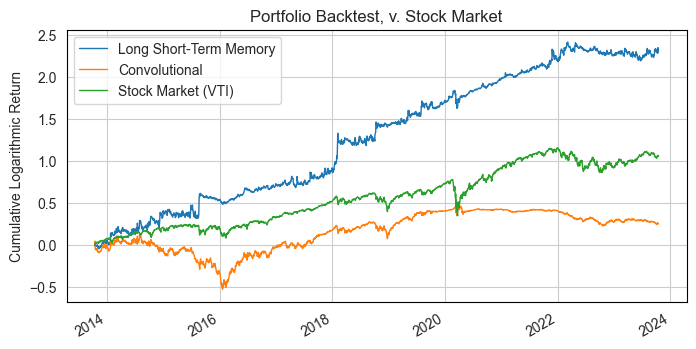

In [8]:
backtest.cumsum().plot(figsize=(8, 4))
plt.title("Portfolio Backtest, v. Stock Market")
plt.ylabel("Cumulative Logarithmic Return")
plt.xlabel("")
plt.legend(["Long Short-Term Memory", "Convolutional", "Stock Market (VTI)"])
plt.show()

In [91]:
backtest.to_csv("workflow/data/backtests/lstm_lev_bt.csv")
with open("workflow/data/optimizations/lstm_lev_opt.pkl", "wb") as f:
    pickle.dump(weights_dfs, f)

In [9]:
optimized_stats = PortfolioStats(backtest, log=True)

optimized_stats.info.sort_values(by="SHARPE", ascending=False)

,SHARPE,CUMU_RET,ANN_RET,ANN_VOL,MAX_DD
LSTM,0.870916,2.305544,0.230646,0.264832,-0.224724
STOCK_MARKET,0.594404,1.063772,0.106419,0.179036,-0.430787
CNN,0.150423,0.251531,0.025163,0.167282,-0.658656


In [12]:
for col in optimized_stats.info.columns:
    print("--", col, "--")
    print(optimized_stats.info[col].sort_values(ascending=False)[:1])
    print()

-- SHARPE --
LSTM    0.870916
Name: SHARPE, dtype: object

-- CUMU_RET --
LSTM    2.305544
Name: CUMU_RET, dtype: object

-- ANN_RET --
LSTM    0.230646
Name: ANN_RET, dtype: object

-- ANN_VOL --
LSTM    0.264832
Name: ANN_VOL, dtype: object

-- MAX_DD --
LSTM   -0.224724
Name: MAX_DD, dtype: object



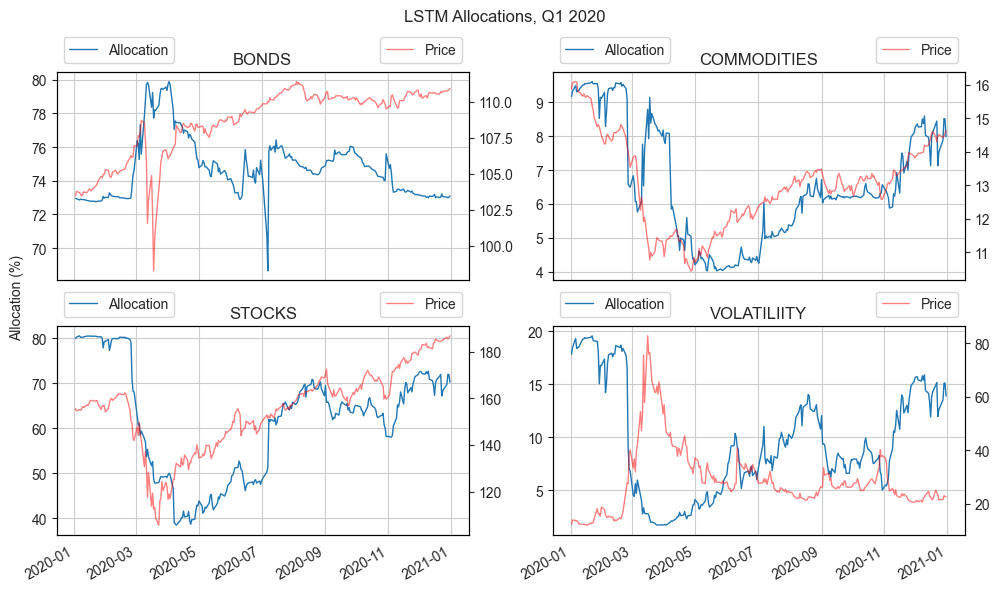

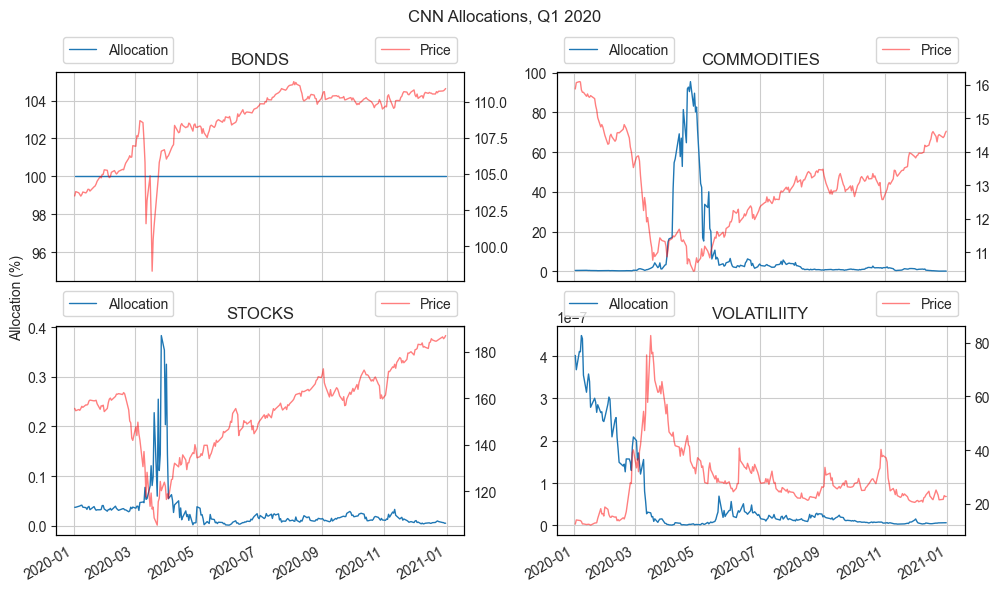

In [92]:
# Plot Q1 2020 (COVID-19) market crash allocations
covid_q1 = {"start": "2020-01", "end": "2020-12"}

for strat in weights.keys():

    fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True)
    fig.suptitle(f"{strat} Allocations, Q1 2020", fontsize=12)

    axes = axes.flatten()
    
    for ax, index in zip(axes, indices):

        ax.set_title(index)
        ax_twin = ax.twinx()
        index_allocation = weights_dfs[strat][index]

        date_allocation = index_allocation.loc[covid_q1["start"]:covid_q1["end"]] * 100
        prices = features[indices].loc[covid_q1["start"]:covid_q1["end"]]

        date_allocation.plot(ax=ax)
        prices[index].plot(ax=ax_twin, grid=False, color="r", alpha=.5)

        ax.set_xlabel("")
        ax.legend(["Allocation"], loc='upper left', bbox_to_anchor=(0,1.2))
        ax_twin.legend(["Price"], loc='upper right', bbox_to_anchor=(1,1.2))

    fig.text(0.005, 0.5, 'Allocation (%)', va='center', rotation='vertical')
    plt.tight_layout()
    plt.show()

In [65]:
for i, (strat, allocations) in enumerate(weights_dfs.items()):
    print(f"""{strat} 
Maximum Leverage:\t{allocations.sum(axis=1).max():,.2f}x
Date:\t\t\t{allocations.sum(axis=1).idxmax().strftime("%b %d, %Y")}
Minimum Leverage:\t{allocations.sum(axis=1).min():,.2f}x
Date:\t\t\t{allocations.sum(axis=1).idxmin().strftime("%b %d, %Y")}
          """)

LSTM 
Maximum Leverage:	2.94x
Date:			Jul 08, 2014
Minimum Leverage:	1.23x
Date:			Apr 23, 2020
          
CNN 
Maximum Leverage:	2.98x
Date:			Feb 19, 2016
Minimum Leverage:	1.00x
Date:			Sep 08, 2021
          


In [72]:
import pandas as pd

# Sample DataFrame, replace with your own data
data = {
    'BONDS': [0.959862, 0.965882],
    'COMMODITIES': [0.309375, 0.347837],
    'STOCKS': [0.870931, 0.890992],
    'VOLATILITY': [0.167620, 0.207006]
}

df = pd.DataFrame(data)

# Annual interest rate for borrowing, replace with your own rate
annual_interest_rate = 0.05  # 5% as an example

# Calculate daily borrowing cost
daily_borrowing_cost = df * (annual_interest_rate / 365)

print(daily_borrowing_cost)


      BONDS  COMMODITIES    STOCKS  VOLATILITY
0  0.000131     0.000042  0.000119    0.000023
1  0.000132     0.000048  0.000122    0.000028


In [90]:
((weights_dfs["LSTM"].sum(axis=1)) - 1).diff() * (0.05/365)

Date
2013-10-14             NaN
2013-10-15    1.423699e-05
2013-10-16    3.144218e-06
2013-10-17   -1.685606e-05
2013-10-18    2.228391e-05
                  ...     
2023-10-10    2.081754e-06
2023-10-11   -6.525484e-08
2023-10-12    1.107405e-06
2023-10-13    1.344648e-06
2023-10-16   -8.725140e-07
Length: 2519, dtype: float32